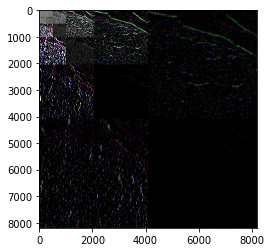

In [3]:
import numpy as np
import pywt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pylab
from tensorflow.python.framework import ops
ops.reset_default_graph()

import matplotlib.pyplot as plt

def dwt2d(x, wave='haar'):
    # shape x: (b, h, w, c)
    nc = int(x.shape.dims[3])
    # wave
    w = pywt.Wavelet(wave)
    # Horizontal low frequency Vertical low frequency
    ll = np.outer(w.dec_lo, w.dec_lo)
    # Horizontal low frequency Vertical high frequency
    lh = np.outer(w.dec_hi, w.dec_lo)
    # Horizontal high frequency Vertical low frequency
    hl = np.outer(w.dec_lo, w.dec_hi)
    # Horizontal high frequency Vertical high frequency
    hh = np.outer(w.dec_hi, w.dec_hi)
    core = np.zeros((np.shape(ll)[0], np.shape(ll)[1], 1, 4))
    core[:, :, 0, 0] = ll[::-1, ::-1]
    core[:, :, 0, 1] = lh[::-1, ::-1]
    core[:, :, 0, 2] = hl[::-1, ::-1]
    core[:, :, 0, 3] = hh[::-1, ::-1]
    core = core.astype(np.float32)
    kernel = np.array([core], dtype=np.float32)
    kernel = tf.convert_to_tensor(kernel)
    p = 2 * (len(w.dec_lo) // 2 - 1)
    with tf.variable_scope('dwt2d'):
        x = tf.pad(x, tf.constant([[0, 0], [p, p+1], [p, p+1], [0, 0]]))
        xh = tf.shape(x)[1] - tf.shape(x)[1]%2
        xw = tf.shape(x)[2] - tf.shape(x)[2]%2
        x = x[:, 0:xh, 0:xw, :]
        x3d = tf.expand_dims(x, 1)
        x3d = tf.split(x3d, int(x3d.shape.dims[4]), 4)
        # concat dimension1
        x3d = tf.concat([a for a in x3d], 1)
        y3d = tf.nn.conv3d(x3d, kernel, padding='VALID', strides=[1, 1, 2, 2, 1])
        # split dimension1
        y = tf.split(y3d, int(y3d.shape.dims[1]), 1)
        # concat
        y = tf.concat([a for a in y], 4)
        y = tf.reshape(y, (tf.shape(y)[0], tf.shape(y)[2], tf.shape(y)[3], 4*nc))
        channels = tf.split(y, nc, 3)
        outputs = []
        for channel in channels:
            (cA, cH, cV, cD) = tf.split(channel, 4, 3)
            AH = tf.concat([cA, cH], axis=2)
            VD = tf.concat([cV, cD], axis=2)
            outputs.append(tf.concat([AH, VD], axis=1))
            pass
        outputs = tf.concat(outputs, axis=-1)
        pass
    return outputs

def wavedec2d(x, level=1, wave='haar'):
    if level == 0:
        return x
    y = dwt2d(x, wave=wave)
    hcA = tf.floordiv(tf.shape(y)[1], 2)
    wcA = tf.floordiv(tf.shape(y)[2], 2)
    cA = y[:, 0:hcA, 0:wcA, :]
    cA = wavedec2d(cA, level=level-1, wave=wave)
    cA = cA[:, 0:hcA, 0:wcA, :]
    hcA = tf.shape(cA)[1]
    wcA = tf.shape(cA)[2]
    cH = y[:, 0:hcA, wcA:, :]
    cV = y[:, hcA:, 0:wcA, :]
    cD = y[:, hcA:, wcA:, :]
    AH = tf.concat([cA, cH], axis=2)
    VD = tf.concat([cV, cD], axis=2)
    outputs = tf.concat([AH, VD], axis=1)
    return outputs

def idwt2d(x, wave='haar'):
    # shape x: (b, h, w, c)
    nc = int(x.shape.dims[3])
    # wave
    w = pywt.Wavelet(wave)
    # Horizontal low frequency Vertical low frequency
    ll = np.outer(w.dec_lo, w.dec_lo)
    # Horizontal low frequency Vertical high frequency
    lh = np.outer(w.dec_hi, w.dec_lo)
    # Horizontal high frequency Vertical low frequency
    hl = np.outer(w.dec_lo, w.dec_hi)
    # Horizontal high frequency Vertical high frequency
    hh = np.outer(w.dec_hi, w.dec_hi)
    core = np.zeros((np.shape(ll)[0], np.shape(ll)[1], 1, 4))
    core[:, :, 0, 0] = ll[::-1, ::-1]
    core[:, :, 0, 1] = lh[::-1, ::-1]
    core[:, :, 0, 2] = hl[::-1, ::-1]
    core[:, :, 0, 3] = hh[::-1, ::-1]
    core = core.astype(np.float32)
    kernel = np.array([core], dtype=np.float32)
    kernel = tf.convert_to_tensor(kernel)
    s = 2 * (len(w.dec_lo) // 2 - 1)
    # Inverse
    with tf.variable_scope('idwt2d'):
        hcA = tf.floordiv(tf.shape(x)[1], 2)
        wcA = tf.floordiv(tf.shape(x)[2], 2)
        y = []
        for c in range(nc):
            channel = x[:, :, :, c]
            channel = tf.expand_dims(channel, -1)
            cA = channel[:, 0:hcA, 0:wcA, :]
            cH = channel[:, 0:hcA, wcA:, :]
            cV = channel[:, hcA:, 0:wcA, :]
            cD = channel[:, hcA:, wcA:, :]
            temp = tf.concat([cA, cH, cV, cD], axis=-1)
            y.append(temp)
            pass
        # nc * 4
        y = tf.concat(y, axis=-1)
        y3d = tf.expand_dims(y, 1)
        y3d = tf.split(y3d, nc, 4)
        y3d = tf.concat([a for a in y3d], 1)
        output_shape = [tf.shape(y)[0], tf.shape(y3d)[1], \
                        2*(tf.shape(y)[1]-1)+np.shape(ll)[0], \
                        2*(tf.shape(y)[2]-1)+np.shape(ll)[1], 1]
        x3d = tf.nn.conv3d_transpose(y3d, kernel, output_shape=output_shape, padding='VALID', strides=[1, 1, 2, 2, 1])
        outputs = tf.split(x3d, nc, 1)
        outputs = tf.concat([x for x in outputs], 4)
        outputs = tf.reshape(outputs, (tf.shape(outputs)[0], tf.shape(outputs)[2], tf.shape(outputs)[3], nc))
        outputs = outputs[:, s:2*(tf.shape(y)[1]-1)+np.shape(ll)[0]-s, \
                          s:2*(tf.shape(y)[2]-1)+np.shape(ll)[1]-s, :]
        pass
    return outputs

# tf.reset_default_graph()
tf.compat.v1.reset_default_graph()
inputs = tf.placeholder(tf.float32, [None, None, None, 3], name='inputs')
# 2048*2048, log2(2048)level, 11, ~11s
# 4096*4096, log2(4096)level, 12, ~35s
# 8192*8192, log2(8192)level, 13, ~1min36s
image = plt.imread('TCGA-05-4245-01Z-00-DX1.36ff5403-d4bb-4415-b2c5-7c750d655cde_05_8192.svs')

# plt.imshow(image)
# plt.show()
x = np.array([image, image[:, ::-1, :]])
dec = wavedec2d(inputs, level=13, wave='haar') 
dwt = dwt2d(inputs, wave='haar')
idwt = idwt2d(dwt, wave='haar')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(dec, feed_dict={inputs:x})
    plt.imshow(np.array(result[0], dtype=np.uint8))
    plt.show()
    trans = sess.run(dwt, feed_dict={inputs:x})
    # plt.imshow(np.array(trans[0], dtype=np.uint8))
    # plt.show()
    # recons = sess.run(idwt, feed_dict={inputs:x})
    # plt.imshow(np.array(recons[0], dtype=np.uint8))
    # plt.show()
    pass


Haar                haar    
Daubechies             db      
Symlets              sym     
Coiflets              coif    
BiorSplines            bior    
ReverseBior            rbio    
Meyer               meyr    
DMeyer               dmey    
Gaussian              gaus    
Mexican_hat            mexh    
Morlet               morl    
Complex Gaussian         cgau    
Shannon              shan    
Frequency B-Spline        fbsp    
Complex Morlet          cmor    
Fejer-Korovkin           fk      
Best-localized Daubechies	    bl      
Morris minimum-bandwidth 		  mb      
Beylkin              beyl    
Vaidyanathan            vaid    
Han linear-phase moments 		 han     


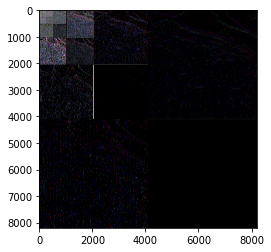

In [4]:
import numpy as np
import pywt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pylab
from tensorflow.python.framework import ops
ops.reset_default_graph()

import matplotlib.pyplot as plt

def dwt2d(x, wave='db4'):
    # shape x: (b, h, w, c)
    nc = int(x.shape.dims[3])
    # wave
    w = pywt.Wavelet(wave)
    # Horizontal low frequency Vertical low frequency
    ll = np.outer(w.dec_lo, w.dec_lo)
    # Horizontal low frequency Vertical high frequency
    lh = np.outer(w.dec_hi, w.dec_lo)
    # Horizontal high frequency Vertical low frequency
    hl = np.outer(w.dec_lo, w.dec_hi)
    # Horizontal high frequency Vertical high frequency
    hh = np.outer(w.dec_hi, w.dec_hi)
    core = np.zeros((np.shape(ll)[0], np.shape(ll)[1], 1, 4))
    core[:, :, 0, 0] = ll[::-1, ::-1]
    core[:, :, 0, 1] = lh[::-1, ::-1]
    core[:, :, 0, 2] = hl[::-1, ::-1]
    core[:, :, 0, 3] = hh[::-1, ::-1]
    core = core.astype(np.float32)
    kernel = np.array([core], dtype=np.float32)
    kernel = tf.convert_to_tensor(kernel)
    p = 2 * (len(w.dec_lo) // 2 - 1)
    with tf.variable_scope('dwt2d'):
        x = tf.pad(x, tf.constant([[0, 0], [p, p+1], [p, p+1], [0, 0]]))
        xh = tf.shape(x)[1] - tf.shape(x)[1]%2
        xw = tf.shape(x)[2] - tf.shape(x)[2]%2
        x = x[:, 0:xh, 0:xw, :]
        x3d = tf.expand_dims(x, 1)
        x3d = tf.split(x3d, int(x3d.shape.dims[4]), 4)
        # concat dimension1
        x3d = tf.concat([a for a in x3d], 1)
        y3d = tf.nn.conv3d(x3d, kernel, padding='VALID', strides=[1, 1, 2, 2, 1])
        # split dimension1
        y = tf.split(y3d, int(y3d.shape.dims[1]), 1)
        # concat
        y = tf.concat([a for a in y], 4)
        y = tf.reshape(y, (tf.shape(y)[0], tf.shape(y)[2], tf.shape(y)[3], 4*nc))
        channels = tf.split(y, nc, 3)
        outputs = []
        for channel in channels:
            (cA, cH, cV, cD) = tf.split(channel, 4, 3)
            AH = tf.concat([cA, cH], axis=2)
            VD = tf.concat([cV, cD], axis=2)
            outputs.append(tf.concat([AH, VD], axis=1))
            pass
        outputs = tf.concat(outputs, axis=-1)
        pass
    return outputs

def wavedec2d(x, level=1, wave='db4'):
    if level == 0:
        return x
    y = dwt2d(x, wave=wave)
    hcA = tf.floordiv(tf.shape(y)[1], 2)
    wcA = tf.floordiv(tf.shape(y)[2], 2)
    cA = y[:, 0:hcA, 0:wcA, :]
    cA = wavedec2d(cA, level=level-1, wave=wave)
    cA = cA[:, 0:hcA, 0:wcA, :]
    hcA = tf.shape(cA)[1]
    wcA = tf.shape(cA)[2]
    cH = y[:, 0:hcA, wcA:, :]
    cV = y[:, hcA:, 0:wcA, :]
    cD = y[:, hcA:, wcA:, :]
    AH = tf.concat([cA, cH], axis=2)
    VD = tf.concat([cV, cD], axis=2)
    outputs = tf.concat([AH, VD], axis=1)
    return outputs

def idwt2d(x, wave='db4'):
    # shape x: (b, h, w, c)
    nc = int(x.shape.dims[3])
    # wave
    w = pywt.Wavelet(wave)
    # Horizontal low frequency Vertical low frequency
    ll = np.outer(w.dec_lo, w.dec_lo)
    # Horizontal low frequency Vertical high frequency
    lh = np.outer(w.dec_hi, w.dec_lo)
    # Horizontal high frequency Vertical low frequency
    hl = np.outer(w.dec_lo, w.dec_hi)
    # Horizontal high frequency Vertical high frequency
    hh = np.outer(w.dec_hi, w.dec_hi)
    core = np.zeros((np.shape(ll)[0], np.shape(ll)[1], 1, 4))
    core[:, :, 0, 0] = ll[::-1, ::-1]
    core[:, :, 0, 1] = lh[::-1, ::-1]
    core[:, :, 0, 2] = hl[::-1, ::-1]
    core[:, :, 0, 3] = hh[::-1, ::-1]
    core = core.astype(np.float32)
    kernel = np.array([core], dtype=np.float32)
    kernel = tf.convert_to_tensor(kernel)
    s = 2 * (len(w.dec_lo) // 2 - 1)
    # Inverse
    with tf.variable_scope('idwt2d'):
        hcA = tf.floordiv(tf.shape(x)[1], 2)
        wcA = tf.floordiv(tf.shape(x)[2], 2)
        y = []
        for c in range(nc):
            channel = x[:, :, :, c]
            channel = tf.expand_dims(channel, -1)
            cA = channel[:, 0:hcA, 0:wcA, :]
            cH = channel[:, 0:hcA, wcA:, :]
            cV = channel[:, hcA:, 0:wcA, :]
            cD = channel[:, hcA:, wcA:, :]
            temp = tf.concat([cA, cH, cV, cD], axis=-1)
            y.append(temp)
            pass
        # nc * 4
        y = tf.concat(y, axis=-1)
        y3d = tf.expand_dims(y, 1)
        y3d = tf.split(y3d, nc, 4)
        y3d = tf.concat([a for a in y3d], 1)
        output_shape = [tf.shape(y)[0], tf.shape(y3d)[1], \
                        2*(tf.shape(y)[1]-1)+np.shape(ll)[0], \
                        2*(tf.shape(y)[2]-1)+np.shape(ll)[1], 1]
        x3d = tf.nn.conv3d_transpose(y3d, kernel, output_shape=output_shape, padding='VALID', strides=[1, 1, 2, 2, 1])
        outputs = tf.split(x3d, nc, 1)
        outputs = tf.concat([x for x in outputs], 4)
        outputs = tf.reshape(outputs, (tf.shape(outputs)[0], tf.shape(outputs)[2], tf.shape(outputs)[3], nc))
        outputs = outputs[:, s:2*(tf.shape(y)[1]-1)+np.shape(ll)[0]-s, \
                          s:2*(tf.shape(y)[2]-1)+np.shape(ll)[1]-s, :]
        pass
    return outputs

# tf.reset_default_graph()
tf.compat.v1.reset_default_graph()
inputs = tf.placeholder(tf.float32, [None, None, None, 3], name='inputs')
# 2048*2048, log2(2048)level, 11, ~11s
# 4096*4096, log2(4096)level, 12, ~35s
# 8192*8192, log2(8192)level, 13, ~1min36s
image = plt.imread('TCGA-05-4245-01Z-00-DX1.36ff5403-d4bb-4415-b2c5-7c750d655cde_05_8192.svs')

# plt.imshow(image)
# plt.show()
x = np.array([image, image[:, ::-1, :]])
dec = wavedec2d(inputs, level=13, wave='db4') 
dwt = dwt2d(inputs, wave='db4')
idwt = idwt2d(dwt, wave='db4')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(dec, feed_dict={inputs:x})
    plt.imshow(np.array(result[0], dtype=np.uint8))
    plt.show()
    trans = sess.run(dwt, feed_dict={inputs:x})
    # plt.imshow(np.array(trans[0], dtype=np.uint8))
    # plt.show()
    # recons = sess.run(idwt, feed_dict={inputs:x})
    # plt.imshow(np.array(recons[0], dtype=np.uint8))
    # plt.show()
    pass

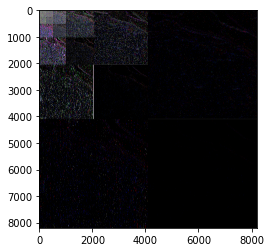

In [5]:
import numpy as np
import pywt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pylab
from tensorflow.python.framework import ops
ops.reset_default_graph()

import matplotlib.pyplot as plt

def dwt2d(x, wave='sym4'):
    # shape x: (b, h, w, c)
    nc = int(x.shape.dims[3])
    # wave
    w = pywt.Wavelet(wave)
    # Horizontal low frequency Vertical low frequency
    ll = np.outer(w.dec_lo, w.dec_lo)
    # Horizontal low frequency Vertical high frequency
    lh = np.outer(w.dec_hi, w.dec_lo)
    # Horizontal high frequency Vertical low frequency
    hl = np.outer(w.dec_lo, w.dec_hi)
    # Horizontal high frequency Vertical high frequency
    hh = np.outer(w.dec_hi, w.dec_hi)
    core = np.zeros((np.shape(ll)[0], np.shape(ll)[1], 1, 4))
    core[:, :, 0, 0] = ll[::-1, ::-1]
    core[:, :, 0, 1] = lh[::-1, ::-1]
    core[:, :, 0, 2] = hl[::-1, ::-1]
    core[:, :, 0, 3] = hh[::-1, ::-1]
    core = core.astype(np.float32)
    kernel = np.array([core], dtype=np.float32)
    kernel = tf.convert_to_tensor(kernel)
    p = 2 * (len(w.dec_lo) // 2 - 1)
    with tf.variable_scope('dwt2d'):
        x = tf.pad(x, tf.constant([[0, 0], [p, p+1], [p, p+1], [0, 0]]))
        xh = tf.shape(x)[1] - tf.shape(x)[1]%2
        xw = tf.shape(x)[2] - tf.shape(x)[2]%2
        x = x[:, 0:xh, 0:xw, :]
        x3d = tf.expand_dims(x, 1)
        x3d = tf.split(x3d, int(x3d.shape.dims[4]), 4)
        # concat dimension1
        x3d = tf.concat([a for a in x3d], 1)
        y3d = tf.nn.conv3d(x3d, kernel, padding='VALID', strides=[1, 1, 2, 2, 1])
        # split dimension1
        y = tf.split(y3d, int(y3d.shape.dims[1]), 1)
        # concat
        y = tf.concat([a for a in y], 4)
        y = tf.reshape(y, (tf.shape(y)[0], tf.shape(y)[2], tf.shape(y)[3], 4*nc))
        channels = tf.split(y, nc, 3)
        outputs = []
        for channel in channels:
            (cA, cH, cV, cD) = tf.split(channel, 4, 3)
            AH = tf.concat([cA, cH], axis=2)
            VD = tf.concat([cV, cD], axis=2)
            outputs.append(tf.concat([AH, VD], axis=1))
            pass
        outputs = tf.concat(outputs, axis=-1)
        pass
    return outputs

def wavedec2d(x, level=1, wave='sym4'):
    if level == 0:
        return x
    y = dwt2d(x, wave=wave)
    hcA = tf.floordiv(tf.shape(y)[1], 2)
    wcA = tf.floordiv(tf.shape(y)[2], 2)
    cA = y[:, 0:hcA, 0:wcA, :]
    cA = wavedec2d(cA, level=level-1, wave=wave)
    cA = cA[:, 0:hcA, 0:wcA, :]
    hcA = tf.shape(cA)[1]
    wcA = tf.shape(cA)[2]
    cH = y[:, 0:hcA, wcA:, :]
    cV = y[:, hcA:, 0:wcA, :]
    cD = y[:, hcA:, wcA:, :]
    AH = tf.concat([cA, cH], axis=2)
    VD = tf.concat([cV, cD], axis=2)
    outputs = tf.concat([AH, VD], axis=1)
    return outputs

def idwt2d(x, wave='db4'):
    # shape x: (b, h, w, c)
    nc = int(x.shape.dims[3])
    # wave
    w = pywt.Wavelet(wave)
    # Horizontal low frequency Vertical low frequency
    ll = np.outer(w.dec_lo, w.dec_lo)
    # Horizontal low frequency Vertical high frequency
    lh = np.outer(w.dec_hi, w.dec_lo)
    # Horizontal high frequency Vertical low frequency
    hl = np.outer(w.dec_lo, w.dec_hi)
    # Horizontal high frequency Vertical high frequency
    hh = np.outer(w.dec_hi, w.dec_hi)
    core = np.zeros((np.shape(ll)[0], np.shape(ll)[1], 1, 4))
    core[:, :, 0, 0] = ll[::-1, ::-1]
    core[:, :, 0, 1] = lh[::-1, ::-1]
    core[:, :, 0, 2] = hl[::-1, ::-1]
    core[:, :, 0, 3] = hh[::-1, ::-1]
    core = core.astype(np.float32)
    kernel = np.array([core], dtype=np.float32)
    kernel = tf.convert_to_tensor(kernel)
    s = 2 * (len(w.dec_lo) // 2 - 1)
    # Inverse
    with tf.variable_scope('idwt2d'):
        hcA = tf.floordiv(tf.shape(x)[1], 2)
        wcA = tf.floordiv(tf.shape(x)[2], 2)
        y = []
        for c in range(nc):
            channel = x[:, :, :, c]
            channel = tf.expand_dims(channel, -1)
            cA = channel[:, 0:hcA, 0:wcA, :]
            cH = channel[:, 0:hcA, wcA:, :]
            cV = channel[:, hcA:, 0:wcA, :]
            cD = channel[:, hcA:, wcA:, :]
            temp = tf.concat([cA, cH, cV, cD], axis=-1)
            y.append(temp)
            pass
        # nc * 4
        y = tf.concat(y, axis=-1)
        y3d = tf.expand_dims(y, 1)
        y3d = tf.split(y3d, nc, 4)
        y3d = tf.concat([a for a in y3d], 1)
        output_shape = [tf.shape(y)[0], tf.shape(y3d)[1], \
                        2*(tf.shape(y)[1]-1)+np.shape(ll)[0], \
                        2*(tf.shape(y)[2]-1)+np.shape(ll)[1], 1]
        x3d = tf.nn.conv3d_transpose(y3d, kernel, output_shape=output_shape, padding='VALID', strides=[1, 1, 2, 2, 1])
        outputs = tf.split(x3d, nc, 1)
        outputs = tf.concat([x for x in outputs], 4)
        outputs = tf.reshape(outputs, (tf.shape(outputs)[0], tf.shape(outputs)[2], tf.shape(outputs)[3], nc))
        outputs = outputs[:, s:2*(tf.shape(y)[1]-1)+np.shape(ll)[0]-s, \
                          s:2*(tf.shape(y)[2]-1)+np.shape(ll)[1]-s, :]
        pass
    return outputs

# tf.reset_default_graph()
tf.compat.v1.reset_default_graph()
inputs = tf.placeholder(tf.float32, [None, None, None, 3], name='inputs')
# 2048*2048, log2(2048)level, 11, ~11s
# 4096*4096, log2(4096)level, 12, ~35s
# 8192*8192, log2(8192)level, 13, ~1min36s
image = plt.imread('TCGA-05-4245-01Z-00-DX1.36ff5403-d4bb-4415-b2c5-7c750d655cde_05_8192.svs')

# plt.imshow(image)
# plt.show()
x = np.array([image, image[:, ::-1, :]])
dec = wavedec2d(inputs, level=13, wave='sym4') 
dwt = dwt2d(inputs, wave='sym4')
idwt = idwt2d(dwt, wave='sym4')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(dec, feed_dict={inputs:x})
    plt.imshow(np.array(result[0], dtype=np.uint8))
    plt.show()
    trans = sess.run(dwt, feed_dict={inputs:x})
    # plt.imshow(np.array(trans[0], dtype=np.uint8))
    # plt.show()
    # recons = sess.run(idwt, feed_dict={inputs:x})
    # plt.imshow(np.array(recons[0], dtype=np.uint8))
    # plt.show()
    pass